## Exploration of the data

In this notebook, we explore the raw data. We perform some vizualisation techniques (PCA, t-Sne), we look at raw data and try to understand the different variables (predictors and response variable). Then, we look at the correlations between independent variables and perform a first multiple linear regression. 

In [1]:
R.version.string

[1] "R version 3.6.1 (2019-07-05)"

In [1]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))

## First look

In [2]:
#First look
head(train.data)
#Maximum and Minimum value of output variable
max <- which.max(train.data$VALENCE.PLEASANTNESS)
min <- which.min(train.data$VALENCE.PLEASANTNESS)
train.data$VALENCE.PLEASANTNESS[min]
train.data$VALENCE.PLEASANTNESS[max]
#Dimension of data
dim(train.data)

,Intensity,VALENCE.PLEASANTNESS,SWEETORSOUR,complexity.from.pubmed,MW,AMW,Sv,Se,Sp,Si,...,Psychotic.80,Psychotic.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
,<fct>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,low,45,FALSE,302.0,208.33,5.952,19.698,34.491,21.523,39.571,...,0,0,1,0,1,0,1,0,1,0
2,high,49,TRUE,72.6,122.18,6.431,11.349,18.745,12.261,21.285,...,0,0,0,0,0,0,0,0,0,0
3,high,56,TRUE,259.0,242.29,7.572,20.832,32.167,21.693,35.535,...,0,0,1,0,1,1,1,0,1,1
4,high,7,FALSE,56.6,88.12,6.294,7.537,14.189,7.955,16.080,...,0,0,0,0,0,0,0,0,0,0
5,low,51,FALSE,84.7,136.21,6.191,12.876,21.629,14.023,24.701,...,0,0,0,0,0,0,0,0,0,0
6,high,21,FALSE,160.0,192.28,6.409,17.644,29.723,19.000,33.740,...,0,0,0,0,1,0,1,0,1,0


[1] 0

[1] 98

[1]  708 4872

## Description of response variable and predictors

Saving 6.67 x 6.67 in image



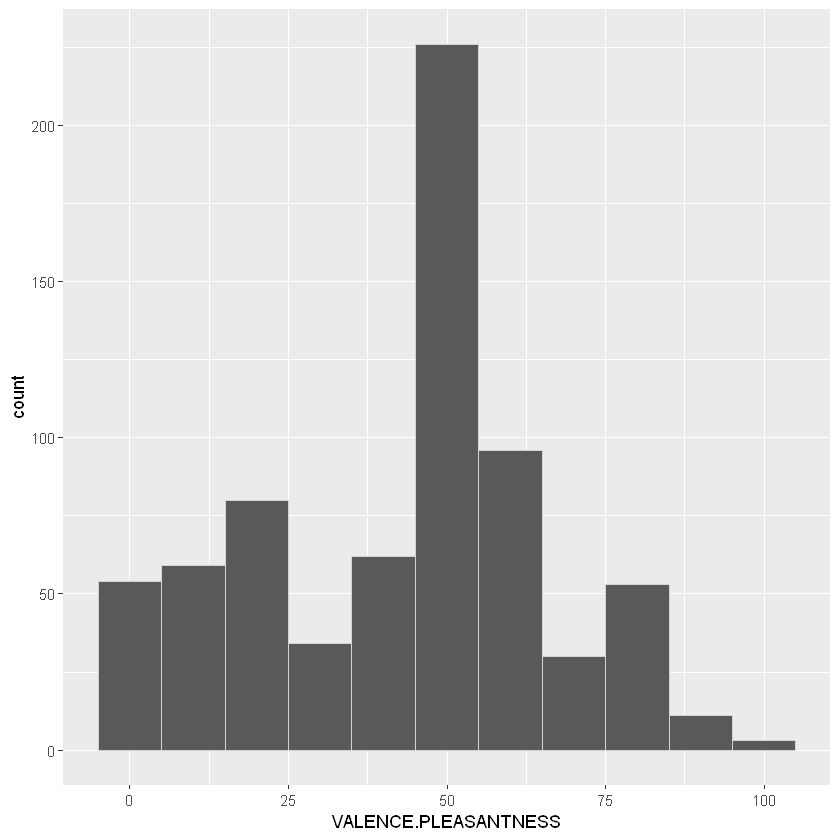

In [3]:
library(ggplot2)
library(magrittr)


train.data %>% ggplot(aes(VALENCE.PLEASANTNESS)) + geom_histogram(binwidth = 10, color = "lightgrey")
ggsave("../Pictures/Response_shape.png")

**Output variable (dependent variable): VALENCE.PLEASANTNESS**
- min. value (in the training set) = 0
- max. value (in the training set) = 98

**Input variables (predictors):**
- 4870 different predictors
- Intensity is a categorical variable with the levels low and high

**SWEETORSOUR:**
- output variable for the second task
- not included in the test set
- not usable for the regression task

## Missing Values 

We will make sure to remove all missing values if there are any

In [4]:
train.data = na.omit(train.data)

## Variance

In [11]:
#convert the variable intensity into 1=low and 0=high (so that we can apply variance and correlation)
numeric.intensity <- as.numeric(train.data$Intensity)-1


In [12]:
#searching for input variables with zero variance 
y <- train.data$VALENCE.PLEASANTNESS
x <- train.data[, -c(2,3)]
x$Intensity <- numeric.intensity
n.before <- dim(x)[2] #numbers of predictors before the reduction
idx.zero.var <- apply(x, 2, var) == 0
x <- x[,!idx.zero.var]
n.after <- dim(x)[2] #numbers of predictors after the reduction

cat("Thereby we could reduce the number of predictors from" , n.before , " to " , n.after)

Thereby we could reduce the number of predictors from 4870  to  3028

## Visualization by PCA and tSNE

In [37]:
library(dplyr)
library("ggplot2")

Saving 6.67 x 6.67 in image



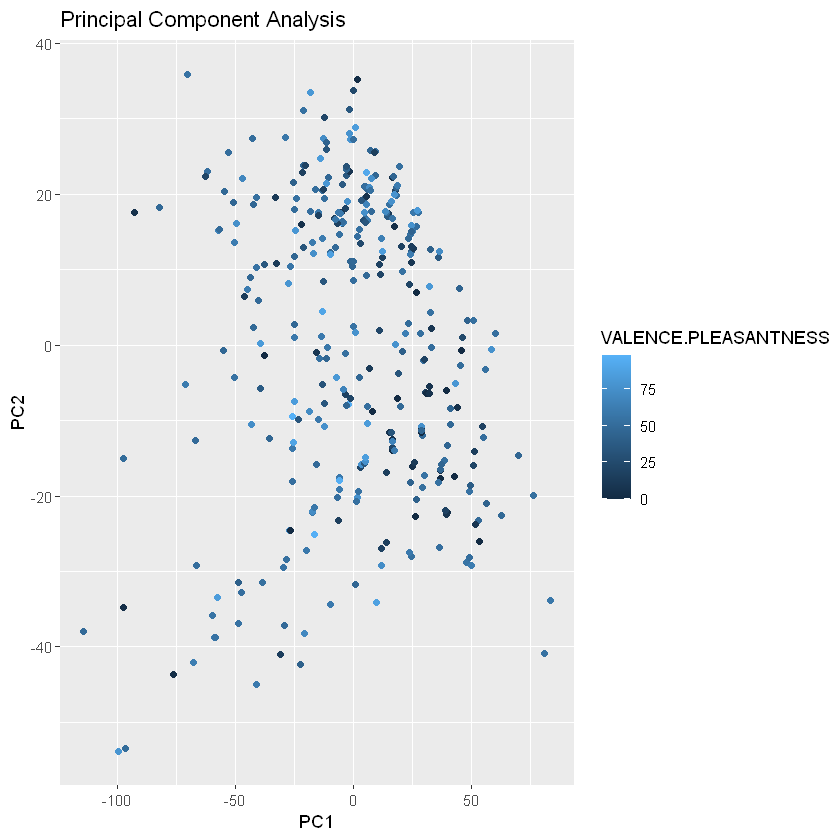

In [38]:
#PCA
pca <- prcomp(x, scale = T)
plot.data <- data.frame("PC1" = pca$x[,1], "PC2" = pca$x[,2], "VALENCE.PLEASANTNESS" = y)
plot.data %>% ggplot(aes(x = PC1, y = PC2, colour = VALENCE.PLEASANTNESS)) + geom_point() + ggtitle("Principal Component Analysis")
ggsave("../Pictures/PCA.png")

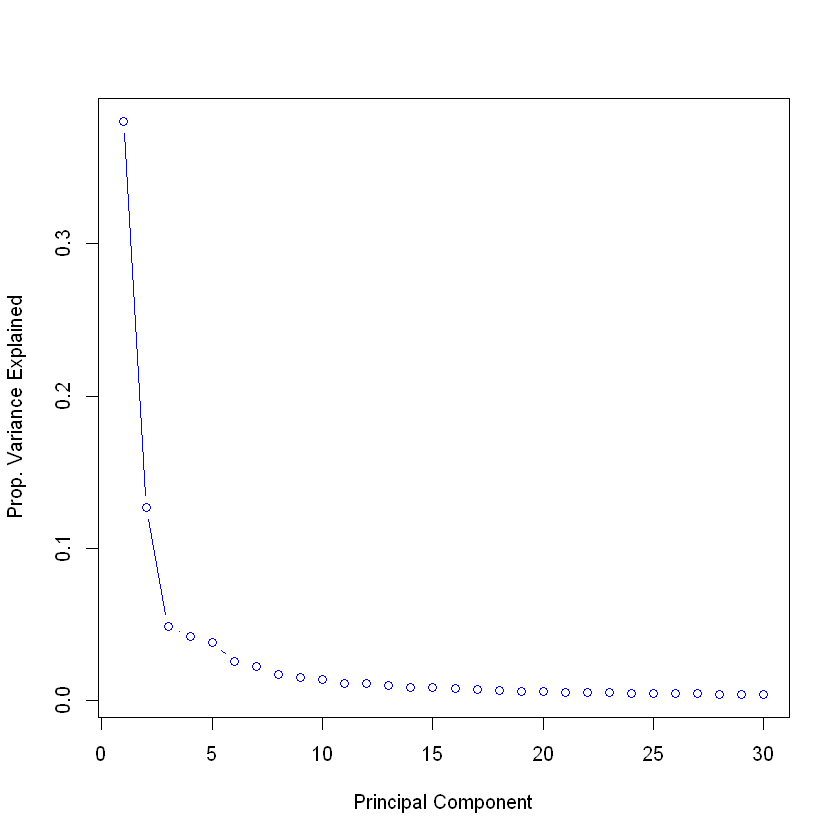

In [39]:
pca.var <- pca$sdev^2
pca.vare <- pca.var / sum(pca.var)
plot(pca.vare[1:30], xlab = "Principal Component", ylab = "Prop. Variance Explained", col = "blue", type = "b")

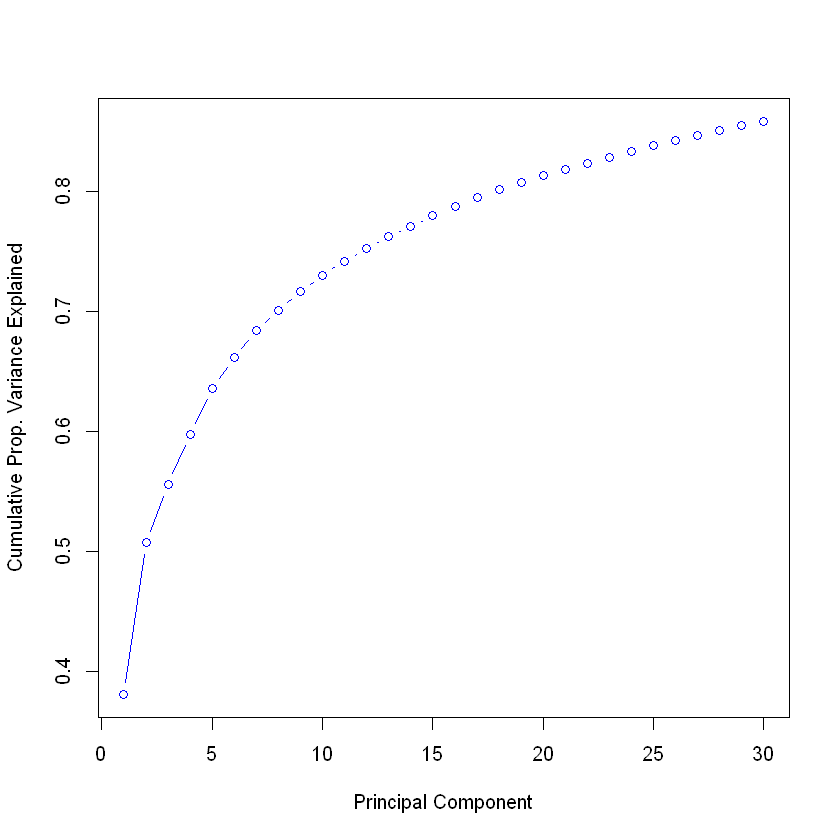

In [40]:

plot(cumsum(pca.vare[1:30]), xlab = "Principal Component", ylab = "Cumulative Prop. Variance Explained", col = "blue", type = "b")


Saving 6.67 x 6.67 in image



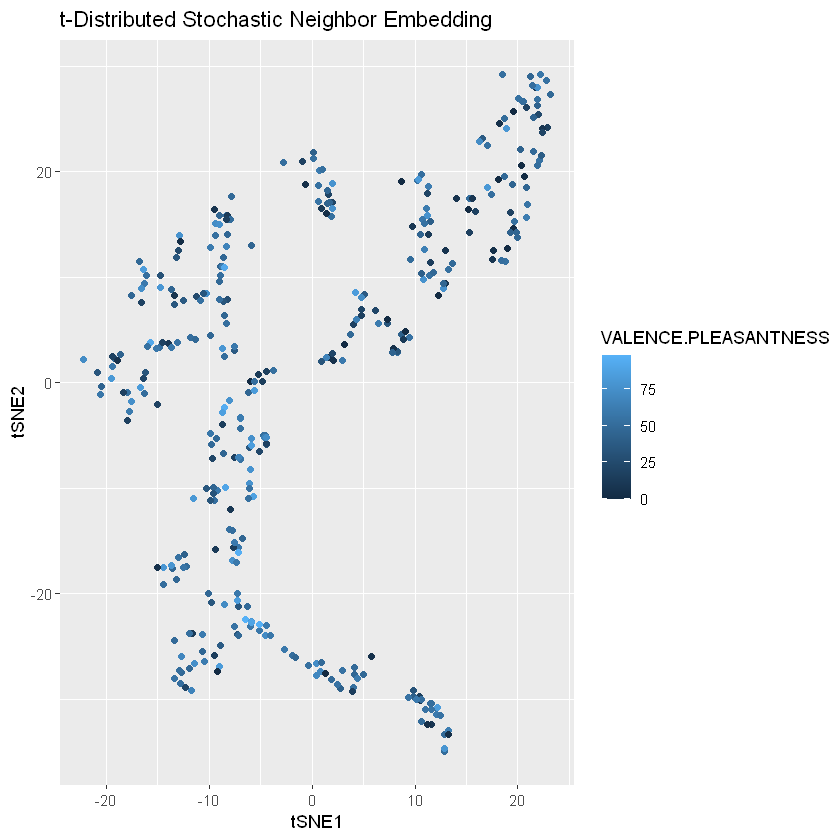

In [41]:
#tSNE
library(Rtsne)
tsne <- Rtsne(x, check_duplicates = FALSE)
plot.data <- data.frame("tSNE1" = tsne$Y[,1], "tSNE2" = tsne$Y[,2], "VALENCE.PLEASANTNESS" = y)
plot.data %>% ggplot(aes(x = tSNE1, y = tSNE2, colour = VALENCE.PLEASANTNESS)) + geom_point() + ggtitle("t-Distributed Stochastic Neighbor Embedding")
ggsave("../Pictures/tSNE.png")



We can not see clusters in PCA nor in tSNE, so that these analyses do not help us.

## First Multiple linear Regression with all predictors

In [5]:
seeds = seq(100,150,1)

RMSE.train = c()
RMSE.validation = c()


for (i in seeds) {
    set.seed(i)
    
    #split the training data in a training set and a validation set for correlated data
    len <- length(x[,1])
    idx.train <- sample(1:len, 2*len/3)

    
    train <- x[idx.train,]
    train$VALENCE.PLEASANTNESS <- y[idx.train]
    validation <- x[-idx.train,]
    validation$VALENCE.PLEASANTNESS <- y[-idx.train]


    full.linear.fit <- lm(VALENCE.PLEASANTNESS ~ ., train)
    full.prediction.train <- predict(full.linear.fit, train)
    RMSE.train <- rbind(RMSE.train, sqrt(mean((full.prediction.train - train$VALENCE.PLEASANTNESS)^2)))

    
    full.prediction.validation <- predict(full.linear.fit, validation)
    RMSE.validation <- rbind(RMSE.validation, sqrt(mean((full.prediction.validation - validation$VALENCE.PLEASANTNESS)^2)))
    
}


Warning message in predict.lm(full.linear.fit, train):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, validation):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, train):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, validation):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, train):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, validation):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, train):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, validation):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, train):
“prediction from a rank-deficient fit

In [6]:
mean.RMSE_train = mean(RMSE.train)
mean.RMSE_val = mean(RMSE.validation)


cat("The mean of the training MSE is ", mean.RMSE_train, "and the variance is ", var(RMSE.train), '\n')
cat("The mean of the validation MSE is ",mean.RMSE_val, "and the variance is ", var(RMSE.validation), '\n')
cat("The median of the validation MSE is ", median(RMSE.validation))

The mean of the training MSE is  11.70863 and the variance is  0.2219616 
The mean of the validation MSE is  39429471 and the variance is  7.476361e+16 
The median of the validation MSE is  14820.12

We can see that the full linear model overfits the data highly. Indeed, we have a value in the range of $10^7$ for the validation MSE, with a huge variance. The median was computed and is in the range of $10^5$. Therefore we have a much more higher validation MSE than training MSE. The corresponding RMSEs and variances are reported on the report file associated with the project. 

We can see now if the validation MSE after multiple linear regression is reduced when counting for correlation between the predictors

## Correlation Analysis 

First, we will look for perfectly correlated data in the dataset 

In [7]:
library(corrplot)
library(caret)
library(plyr)

#searching for variables with correlation = 1
corrMatrix <- cor(x) # Access the correlation matrix (Pearson's coefficients)

highlyCorrelated <- findCorrelation(corrMatrix, cutoff = 1)  # dedects all indices of features which have a correltion of 1
length(highlyCorrelated)

corrplot 0.84 loaded
Loading required package: lattice
Loading required package: ggplot2


[1] 0

There are zero variables which have a correlation index of 1. Hence no variables are completly correlated to each other. We can try to reduce the predictors with 0.95 correlation (or higher) and see if redoing a regression with Multiple Linear Regression gives us a smaller validation MSE.

In [8]:
#searching for variables with correlation = 0.95
corrMatrix <- cor(x) # Access the correlation matrix (Pearson's coefficients)
highlyCorrelated <- findCorrelation(corrMatrix, cutoff = 0.95)  # removes all indices of features which have a correlation of 0.95 or above
highlyCorrCol <- colnames(x)[highlyCorrelated]
corr.x <- x[, -which(colnames(x) %in% highlyCorrCol)]  #Data frame with only uncorrelated data
dim(corr.x)

[1]  708 1195

It leads to a reduction of dimension from 3026 to 1195 predictors.
Now, let's split the training data into a training and a validation set and repeat linear regression on this new data set.

In [11]:
seeds = seq(100,150,1)

RMSE.train = c()
RMSE.validation = c()


for (i in seeds) {
    set.seed(i)
    
    
    #split the training data in a training set and a validation set for correlated data
    len <- length(x[,1])
    idx.train <- sample(1:len, 2*len/3)
    
    corr.train <- corr.x[idx.train,]
    corr.train$VALENCE.PLEASANTNESS <- y[idx.train]
    corr.validation <- corr.x[-idx.train,]
    corr.validation$VALENCE.PLEASANTNESS <- y[-idx.train]


    full.linear.fit <- lm(VALENCE.PLEASANTNESS ~ ., corr.train)
    full.prediction.corr.train <- predict(full.linear.fit, corr.train)
    RMSE.train <- rbind(RMSE.train, sqrt(mean((full.prediction.corr.train - corr.train$VALENCE.PLEASANTNESS)^2)))

    
    full.prediction.validation <- predict(full.linear.fit, corr.validation)
    RMSE.validation <- rbind(RMSE.validation, sqrt(mean((full.prediction.validation - corr.validation$VALENCE.PLEASANTNESS)^2)))
    
}

Warning message in predict.lm(full.linear.fit, corr.train):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, corr.validation):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, corr.train):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, corr.validation):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, corr.train):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, corr.validation):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, corr.train):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, corr.validation):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, corr.

In [12]:
mean.RMSE_train = mean(RMSE.train)
mean.RMSE_val = mean(RMSE.validation)

cat("The mean of the training MSE is ", mean.RMSE_train, "and the variance is ", var(RMSE.train), '\n')
cat("The mean of the validation MSE is ",mean.RMSE_val, "and the variance is ", var(RMSE.validation), '\n')
#cat("The median of the validation MSE is ", median(MSE.validation))

The mean of the training MSE is  11.70856 and the variance is  0.2220049 
The mean of the validation MSE is  76550.12 and the variance is  92101205464 


We can observe that the validation MSE is not significantly reduced after having removed the correlated variables when running a multiple linear regression. We obtain similar orders of magnitude for both set of variables. 

We will move on to Linear Methods that penalizes the flexibility of the model. In fact, as we have much more predictors than variables, our model is too flexible and it results in overfitting the training set. Some well known methods such as Lasso Regularization, Forward Selection with cross-validation will be used to try to reduce the validation MSE by penalizing and reducing some predictors to 0.